# Training 1/3 resolution models (318px)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import rioxarray
import rasterio
import re
import matplotlib.patches as patches
from tqdm import tqdm

from levee_hunter.levees_dataset import LeveesDataset
from levee_hunter.train_test_val_splitting import *
from levee_hunter.modeling.train import train_model
from levee_hunter.modeling.inference import get_preds_targets
from levee_hunter.modeling.metrics import get_pred_mask, plot_skeletons, custom_metrics, standard_metrics
from levee_hunter.plotting import plot, plot_training_validation_loss
from levee_hunter.modeling.inference import infer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss


### Creating Dataset

In [3]:
dataset = LeveesDataset(
    images_dir='/share/gpu5/ucapmgb/levee-hunter/data/processed/_testing/13_384_invert/images',
    masks_dir='/share/gpu5/ucapmgb/levee-hunter/data/processed/_testing/13_384_invert/masks',
    transform=None,
    weighted=True,
    )

# Validation set split
dataset, val_dataset = validation_split(dataset=dataset, val_percentage=0.1, seed=42)
print("Validation dataset: ", len(val_dataset))
val_dataset.weighted = False

# Test set split
train_dataset, test_dataset = train_test_split_dataset(dataset=dataset, test_size=0.1)
print("Test dataset: ", len(test_dataset))
test_dataset.weighted = False

Validation dataset:  141
Test dataset:  118


### Create Data Loaders

In [4]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

### Training Model

In [41]:
# Define a combined loss function that uses both BCE and Dice loss
class DiceBCELoss(nn.Module):
   def __init__(self, bce_weight=0.5, dice_weight=0.5, mode='binary'):
      super(DiceBCELoss, self).__init__()
      self.bce_weight = bce_weight
      self.dice_weight = dice_weight
      self.bce = nn.BCEWithLogitsLoss()
      self.dice = DiceLoss(mode=mode)
      
   def forward(self, y_pred, y_true):
      bce_loss = self.bce(y_pred, y_true)
      dice_loss = self.dice(y_pred, y_true)
      return self.bce_weight * bce_loss + self.dice_weight * dice_loss

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [43]:
model = smp.UnetPlusPlus(
    encoder_name="resnet50", encoder_weights="imagenet", in_channels=1, classes=1
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

model, train_loss_list, test_loss_list = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=DiceBCELoss(),
    epochs=25,
    save_model='best',
    save_model_path="../models/Unet-13_384_invert.pth",
)

beginning training on device: cuda
Epoch: 1/25 Train Loss: 0.682234 Test Loss: 0.005387
Train Levee Loss: 0.684386 (816.0) Train Non-Levee Loss: 0.679813 (241.0)
Test Levee Loss: 0.635697 (82.0) Test Non-Levee Loss: 0.635697 (36.0)
Model successfully saved to: ../models/Unet-13_384_invert.pth
Epoch: 2/25 Train Loss: 0.609038 Test Loss: 0.005049
Train Levee Loss: 0.608643 (823.0) Train Non-Levee Loss: 0.609507 (234.0)
Test Levee Loss: 0.595793 (82.0) Test Non-Levee Loss: 0.595793 (36.0)
Model successfully saved to: ../models/Unet-13_384_invert.pth
Epoch: 3/25 Train Loss: 0.588429 Test Loss: 0.004900
Train Levee Loss: 0.588109 (826.0) Train Non-Levee Loss: 0.587898 (231.0)
Test Levee Loss: 0.578231 (82.0) Test Non-Levee Loss: 0.578231 (36.0)
Model successfully saved to: ../models/Unet-13_384_invert.pth
Epoch: 4/25 Train Loss: 0.577246 Test Loss: 0.004809
Train Levee Loss: 0.576981 (818.0) Train Non-Levee Loss: 0.577281 (239.0)
Test Levee Loss: 0.567441 (82.0) Test Non-Levee Loss: 0.56744

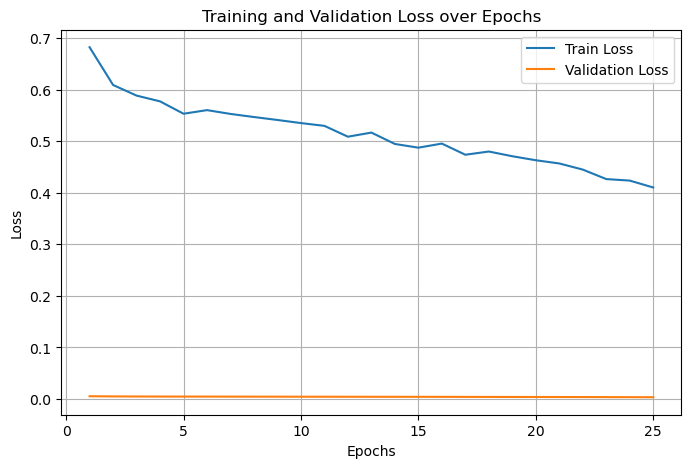

In [44]:
plot_training_validation_loss(train_loss_list, test_loss_list)

### Validating Model

In [45]:
# load saved model
model.load_state_dict(torch.load("../models/Unet-13_384_invert.pth"))
model.eval()

UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

In [46]:
# Get predictions
preds, targets = get_preds_targets(model=model, val_loader=val_loader, device=device)

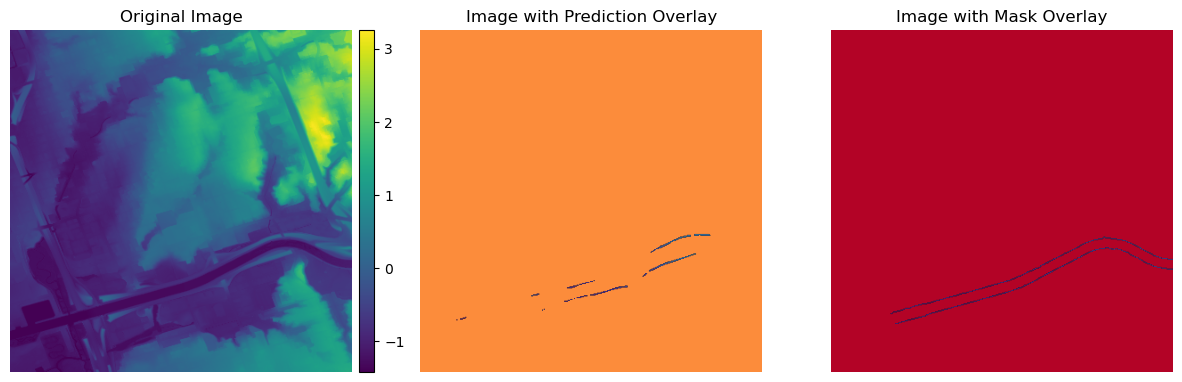

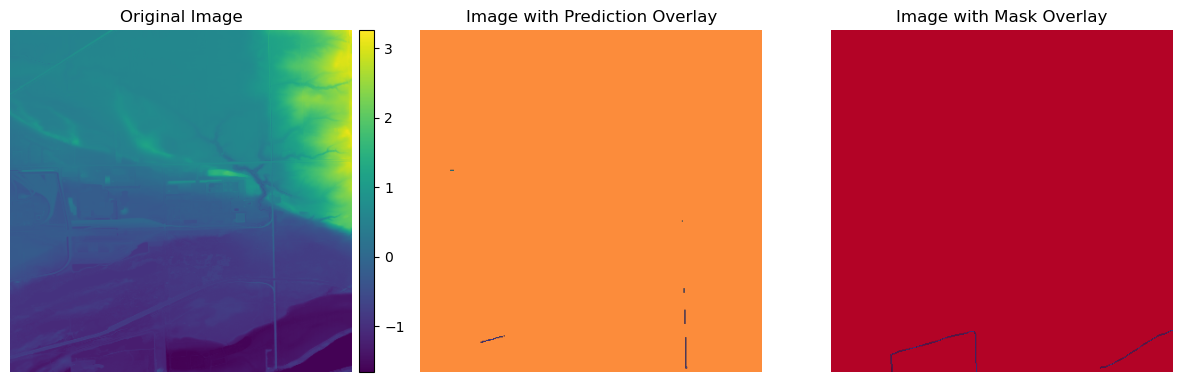

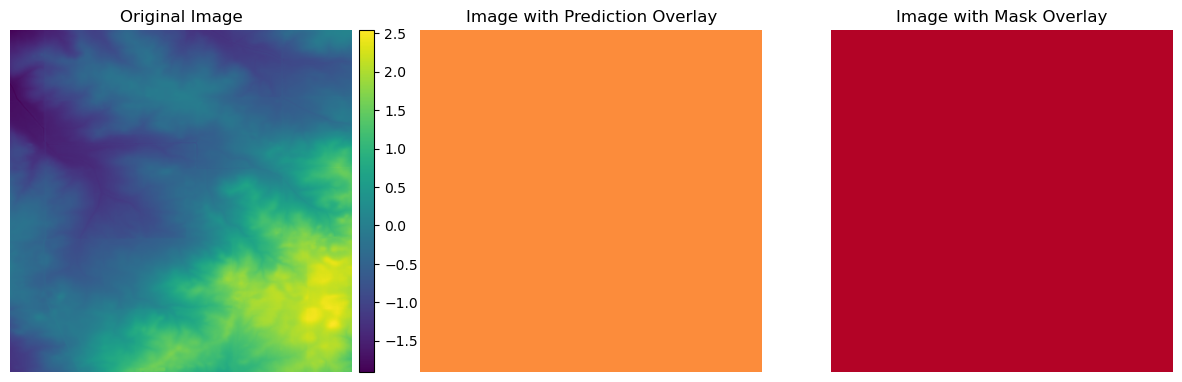

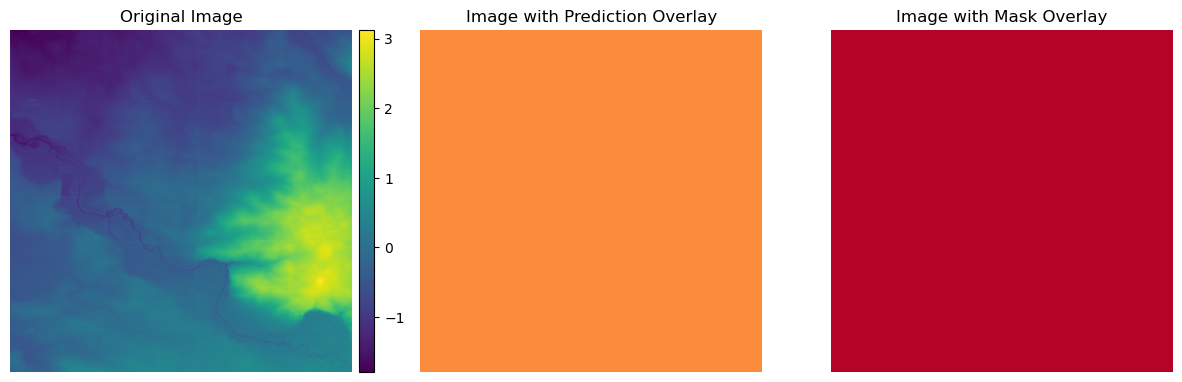

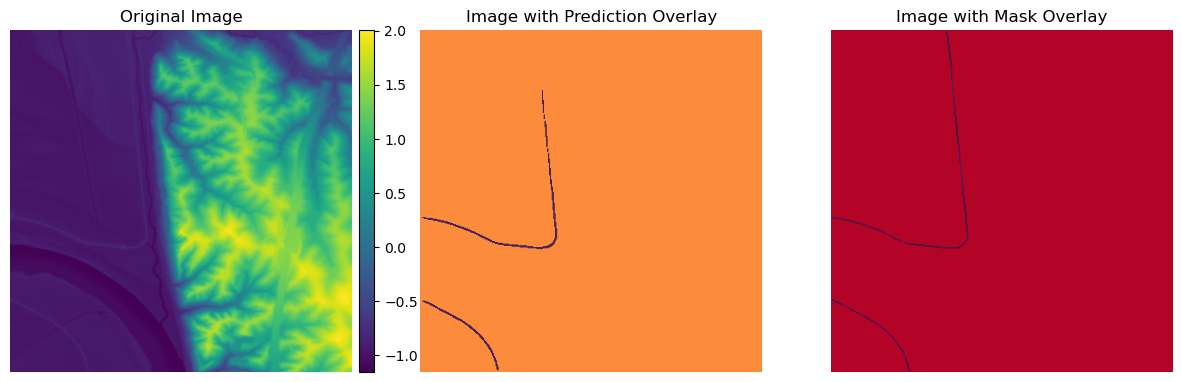

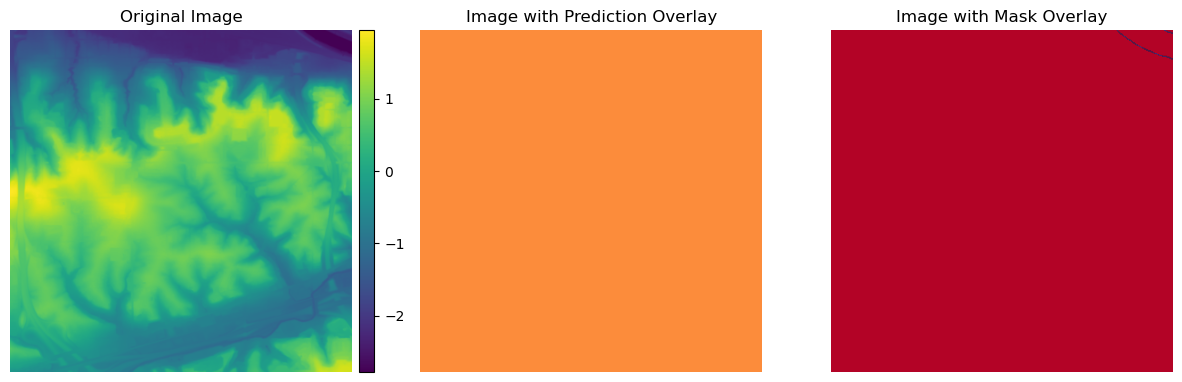

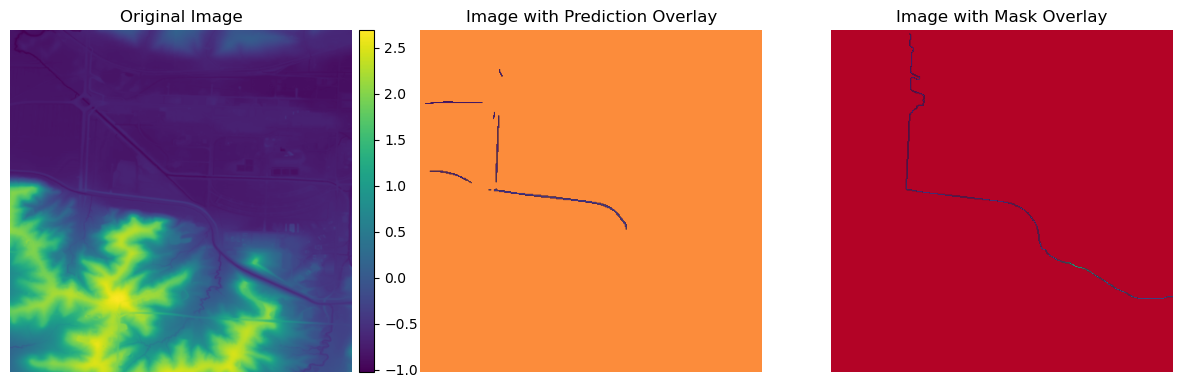

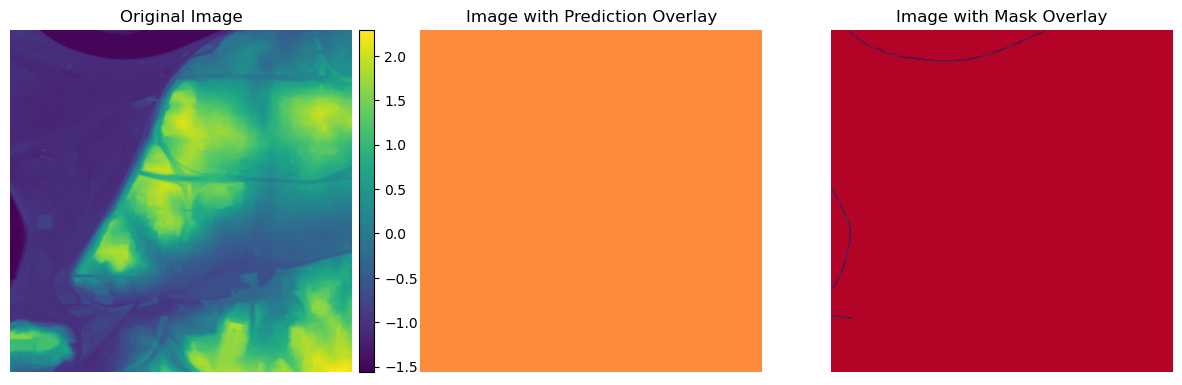

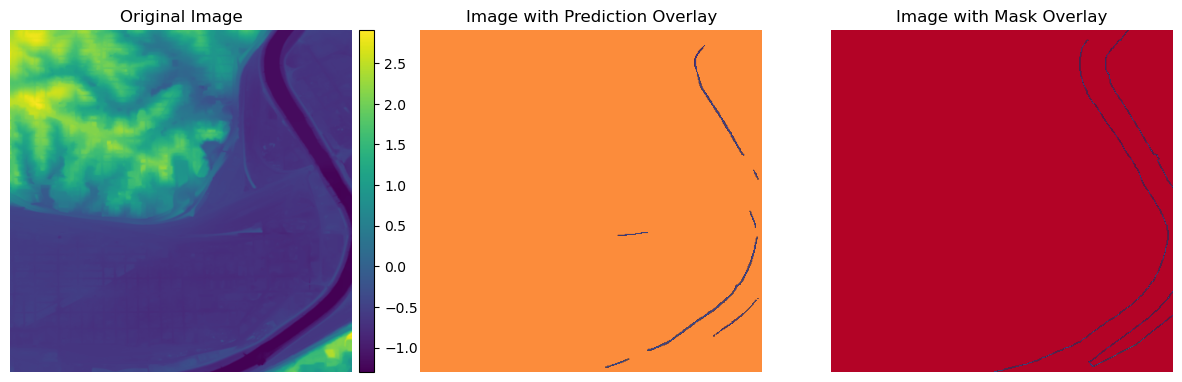

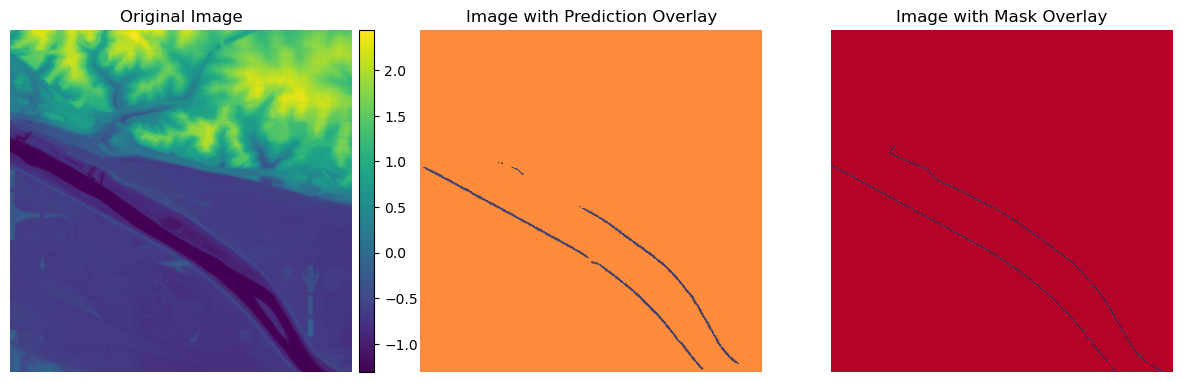

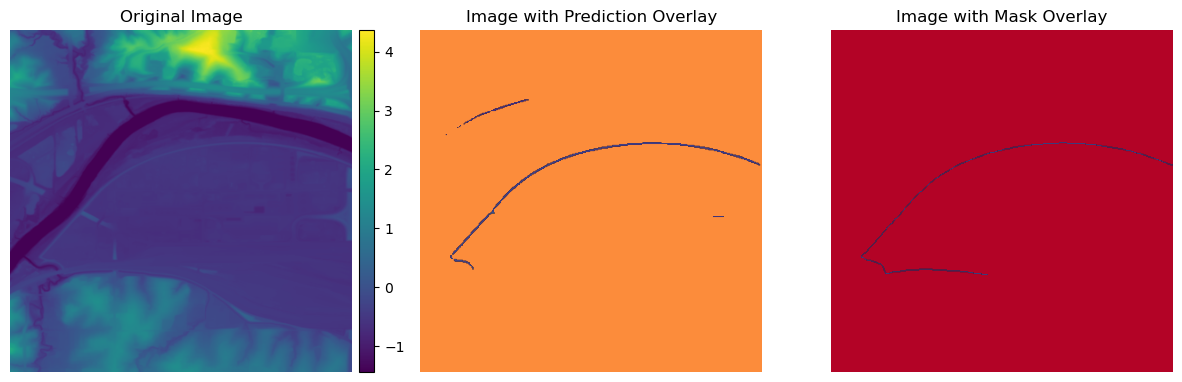

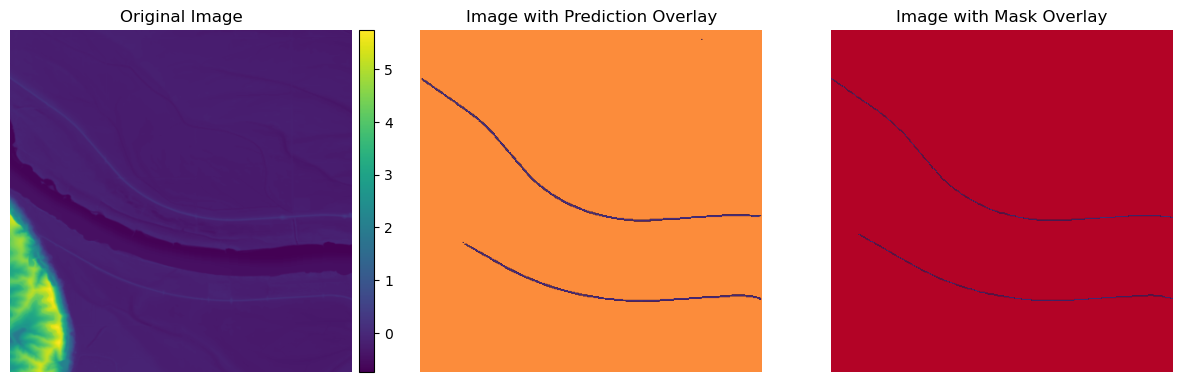

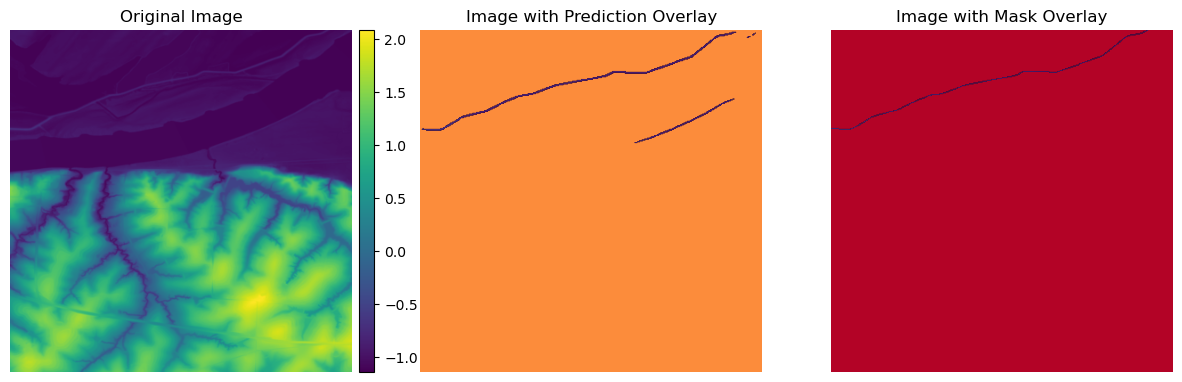

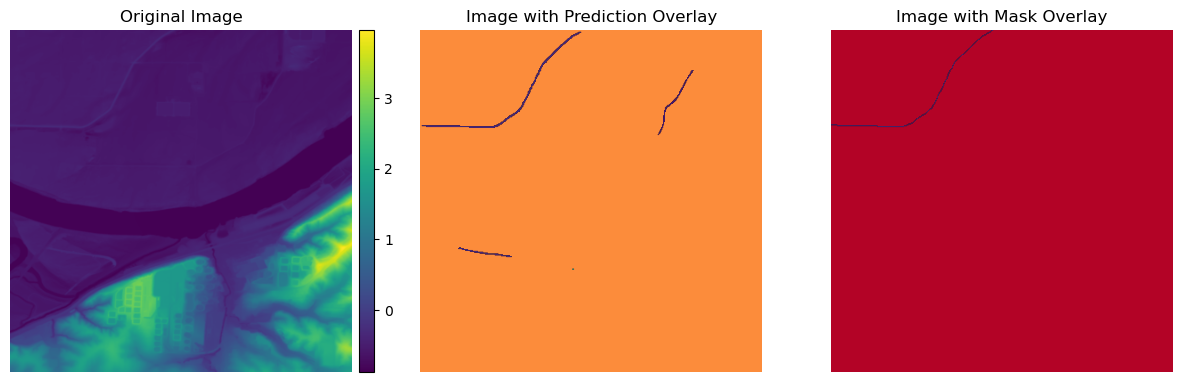

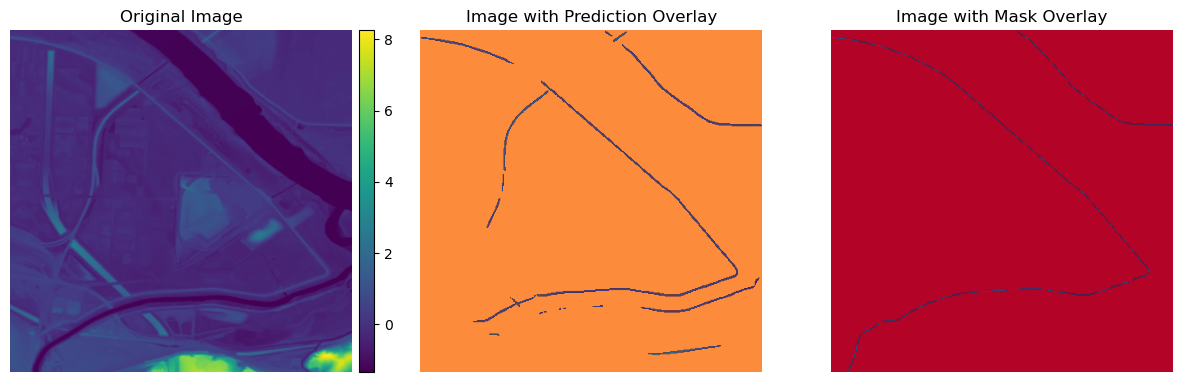

In [47]:
for ix in range(15):
    sample_image, sample_mask = val_dataset[-ix]
    prediction = infer(model=model, image=sample_image, device=device, apply_sigmoid=True, threshold=0.5)
    
    plot(
        image=sample_image, 
        mask=sample_mask, 
        pred=prediction, 
        plot_types=['image', 'image_pred_overlay', 'image_mask_overlay'], 
        powernorm_threshold=30
        )

In [48]:
import scipy.spatial as spatial
# Hausdorff distance
def hausdorff_distance(pred, target):
    pred = pred.squeeze(0).cpu().numpy()
    target = target.squeeze(0).cpu().numpy()

    pred_coords = np.argwhere(pred > 0.5)
    target_coords = np.argwhere(target > 0.5)

    if len(pred_coords) == 0 or len(target_coords) == 0:
        return float('inf')

    pred_tree = spatial.KDTree(pred_coords)
    target_tree = spatial.KDTree(target_coords)

    pred_to_target_distances, _ = pred_tree.query(target_coords)
    target_to_pred_distances, _ = target_tree.query(pred_coords)

    return max(np.max(pred_to_target_distances), np.max(target_to_pred_distances))


Mean Hausdorff Distance: 1.0613603093305604


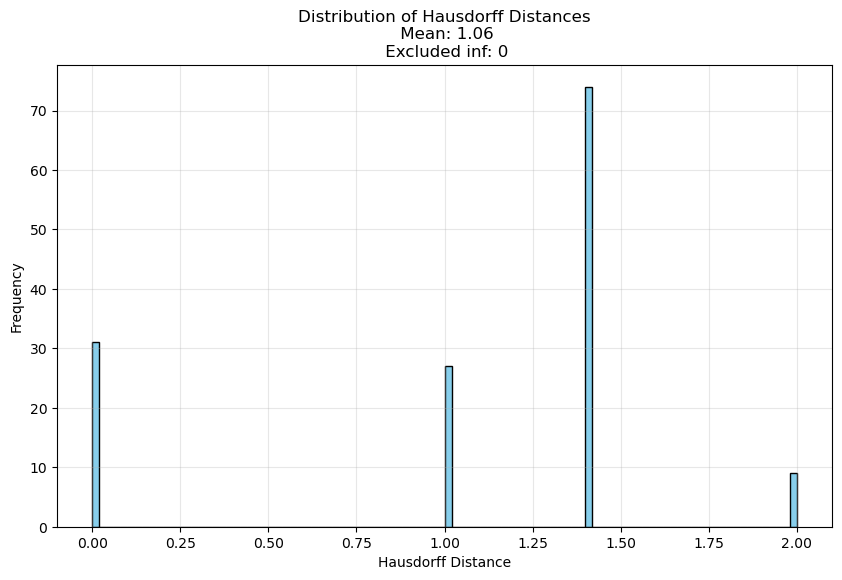

In [49]:
all_preds, all_targets = get_preds_targets(model=model, val_loader=val_loader, device=device)
hausdorff_distances = []
for pred, target in zip(all_preds, all_targets):
    distance = hausdorff_distance(pred, target)
    hausdorff_distances.append(distance)

# Calculate the mean Hausdorff distance
mean_hausdorff_distance = np.mean(hausdorff_distances)
print(f"Mean Hausdorff Distance: {mean_hausdorff_distance}")

# Print histogram
# Filter out inf values for better visualization
finite_distances = [d for d in hausdorff_distances if not np.isinf(d)]
plt.figure(figsize=(10, 6))
plt.hist(finite_distances, bins=100, color='skyblue', edgecolor='black')
plt.title(f'Distribution of Hausdorff Distances\n Mean: {mean_hausdorff_distance:.2f}\n Excluded inf: {len(hausdorff_distances) - len(finite_distances)}')
plt.xlabel('Hausdorff Distance')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)

In [50]:
standard_metrics(targets=all_targets, predictions=all_preds, threshold=0.5)

----------------------Standard Metrics----------------------
IoU Score:         0.9957
F1 Score (Dice):   0.9979
Accuracy:          0.9958
Recall:            0.9968
------------------------------------------------------------
